## Part 1 - Produce Data
We elected to use the datagen connector to generate fake data for this assignment. The topic we used was 'stocktrades. The steps were as follows:
*  Open a browser and go to http://localhost:9021/
*  Select the available cluster
*  On the menu bar, select Connect
*  Click on the connect-default cluster in the Connect Clusters list.
*  Click on Add connector
*  Select DatagenConnector
*  Enter connector_stock_trades in the Name field

Then:
Generate a data stream with following configurations:
```
{
  "name": "connector_stock_trades",
  "connector.class": "io.confluent.kafka.connect.datagen.DatagenConnector",
  "key.converter": "org.apache.kafka.connect.storage.StringConverter",
  "kafka.topic": "stocktrades",
  "max.interval": "100",
  "quickstart": "Stock_Trades"
}
```


## Part 2 - Using Ksql to create at least 2 streams with filtering from topics

To begin, you need to create a stream called stocktrades with no filtering in place.

### Create JSON Stream
In order for this to play nicely with spark, we need to mimic the raw stream as a json formatted stream.

### Stream 1 - Sell Stream
It may be in the interest of the business to view only streams where the stock was sold and not bought. This would be useful in identifying which shares should be taken as a 'short' position

### Stream 2 - Buy Stream
It may also be interesting to the business to see trades that were large buys.

### Table 1 - Aggregated Buy Trades


### Table 2 - Aggregated Sell Trades

## Part 3 - Consume/Transform data with Spark Streaming

### Set up Spark Session

In [1]:
from pyspark.sql import SparkSession
from IPython.display import display, clear_output
import time
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StringType, StructField, IntegerType, FloatType, BinaryType

In [2]:
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

In [3]:
spark.version

'3.1.1'

In [4]:
spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion()

'3.2.0'

## Building a Stream
The code below just walks through how the stream is built. A streamlined function is built for part 3a below.

Firstly, we need to connect to our raw JSON stream 'STOCKTRADES_JSON'.

In [5]:
stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "earliest") \
  .option("subscribe", "STOCKTRADES_JSON") \
  .load()

In [6]:
stream_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



create a stream to view the output.

In [7]:
raw_stream = stream_df \
    .writeStream \
    .format("memory") \
    .queryName("raw_stocktrades_view") \
    .start()

In [10]:
clear_output(wait=True)
display(spark.sql('SELECT key, value FROM raw_stocktrades_view').show(20))
time.sleep(1)

+----+--------------------+
| key|               value|
+----+--------------------+
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
|null|[7B 22 53 49 44 4...|
+----+--------------------+
only showing top 20 rows



None

Despite the key being NULL, the key is equivalent to the `value.symbol` field as shown in confluent. We are happy to proceed without this data.

In [11]:
raw_stream.stop()

### Convert Key Value pairs to strings
Converting to strings allows us to read the actual content of the key and value. Above the values are in hexadecimal binary, which doesnt make sesne to a human.

In [12]:
string_stream_df = stream_df \
    .withColumn("key", stream_df["key"].cast(StringType())) \
      .withColumn('value', stream_df["value"].cast(StringType()))

In [13]:
string_stream = string_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("string_stocktrades_view") \
    .start()

In [15]:
clear_output(wait=True)
display(spark.sql('SELECT key, value FROM string_stocktrades_view').show(20))
time.sleep(1)

+----+--------------------+
| key|               value|
+----+--------------------+
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"BUY","QU...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"SELL","Q...|
|null|{"SIDE":"BUY","QU...|
+----+--------------------+
only showing top 20 rows



None

In [16]:
string_stream.stop()

## Transformation

For future parts, we will need the data in a tidy format, not a JSON format. To do this, we need to outline the JSON structure of the data. and use the inbuilt `from_json` function from Spark to read in the data.

In [17]:
schema_stocktrades =  StructType([
        StructField("SIDE", StringType(),  True),
        StructField("QUANTITY", IntegerType(),  True),
        StructField("PRICE", IntegerType(),  True),
        StructField("SYMBOL", StringType(),  True),
        StructField("ACCOUNT", StringType(), True),
         StructField("USERID", StringType(), True)
])

In [18]:
json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrades))

In [19]:
json_stream_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- SIDE: string (nullable = true)
 |    |-- QUANTITY: integer (nullable = true)
 |    |-- PRICE: integer (nullable = true)
 |    |-- SYMBOL: string (nullable = true)
 |    |-- ACCOUNT: string (nullable = true)
 |    |-- USERID: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [20]:
json_stream = json_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("extract_stocktrades_view") \
    .start()

In [24]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM extract_stocktrades_view').show(20, False))
time.sleep(1)

+----+----------------------------------------+----------------+---------+------+-----------------------+-------------+
|key |value                                   |topic           |partition|offset|timestamp              |timestampType|
+----+----------------------------------------+----------------+---------+------+-----------------------+-------------+
|null|{BUY, 1934, 893, ZTEST, ABC123, User_8} |STOCKTRADES_JSON|0        |0     |2021-06-11 00:40:34.802|0            |
|null|{SELL, 1401, 379, ZVV, ABC123, User_4}  |STOCKTRADES_JSON|0        |1     |2021-06-11 00:40:34.837|0            |
|null|{SELL, 2310, 848, ZJZZT, LMN456, User_6}|STOCKTRADES_JSON|0        |2     |2021-06-11 00:40:34.897|0            |
|null|{BUY, 35, 845, ZWZZT, LMN456, User_2}   |STOCKTRADES_JSON|0        |3     |2021-06-11 00:40:34.989|0            |
|null|{BUY, 3883, 503, ZBZX, ABC123, User_8}  |STOCKTRADES_JSON|0        |4     |2021-06-11 00:40:35.077|0            |
|null|{SELL, 2137, 88, ZWZZT, ABC123, Us

None

In [25]:
json_stream.stop()

### Flatten Data
Finally, we need to separate the data that is in the value field into individual columns.

In [26]:
stocktrades_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.side", \
        "value.quantity", \
        "value.price", \
        "value.symbol", \
        "value.account", \
        "value.userid"
    )

In [27]:
stocktrades_stream_df.printSchema()

root
 |-- event_key: string (nullable = true)
 |-- event_topic: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- side: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- account: string (nullable = true)
 |-- userid: string (nullable = true)



In [28]:
stocktrades_stream = stocktrades_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrades_view") \
    .start()

In [32]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrades_view').show(20))
time.sleep(1)

+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|event_key|     event_topic|     event_timestamp|side|quantity|price|symbol|account|userid|
+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|    1934|  893| ZTEST| ABC123|User_8|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...|SELL|    1401|  379|   ZVV| ABC123|User_4|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...|SELL|    2310|  848| ZJZZT| LMN456|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|      35|  845| ZWZZT| LMN456|User_2|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|    3883|  503|  ZBZX| ABC123|User_8|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...|SELL|    2137|   88| ZWZZT| ABC123|User_5|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|    3459|   21|  ZBZX| XYZ789|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 00:40:...| BUY|     828|  253|  ZBZX| XYZ

None

In [33]:
stocktrades_stream.stop()

## Part 3a - Build at least 2 Spark Streaming dataframes
This function generates a stream from stocktrades with one line of code so its easier to call in later components. It is equivalent to the structure outlined above. 

In [5]:
def generate_stocktrades_stream(keep_stream = False):
    
    # Define the raw Spark Stream
    stream_df = spark \
      .readStream \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "broker:29092") \
      .option("startingOffsets", "latest") \
      .option("subscribe", "STOCKTRADES_JSON") \
      .load()
    
    # Convert to string types for JSON conversion
    string_stream_df = stream_df \
        .withColumn("key", stream_df["key"].cast(StringType())) \
        .withColumn('value', stream_df["value"].cast(StringType()))
    
    # Define the Schema for the end JSON format
    schema_stocktrades =  StructType([
        StructField("SIDE", StringType(),  True),
        StructField("QUANTITY", IntegerType(),  True),
        StructField("PRICE", IntegerType(),  True),
        StructField("SYMBOL", StringType(),  True),
        StructField("ACCOUNT", StringType(), True),
        StructField("USERID", StringType(), True)
])
    # Convert the string type to json format stream
    json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrades))
    stocktrades_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.side", \
        "value.quantity", \
        "value.price", \
        "value.symbol", \
        "value.account", \
        "value.userid"
    )
    
    # Export a queryable view od the stream
    
    if not keep_stream:
        return stocktrades_stream_df \
        .writeStream \
        .format("memory") \
        .queryName("stocktrades_view") \
        .start()
    else:
        return stocktrades_stream_df \
        .writeStream \
        .format("memory") \
        .queryName("stocktrades_view") \
        .start(), stocktrades_stream_df

In [6]:
stocktrades_stream = generate_stocktrades_stream()

In [8]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrades_view').show(20))
time.sleep(1)

+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|event_key|     event_topic|     event_timestamp|side|quantity|price|symbol|account|userid|
+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|     null|STOCKTRADES_JSON|2021-06-11 03:00:...|SELL|    1257|  877|   ZVV| XYZ789|User_4|
|     null|STOCKTRADES_JSON|2021-06-11 03:00:...|SELL|    4221|  995| ZXZZT| LMN456|User_8|
|     null|STOCKTRADES_JSON|2021-06-11 03:00:...| BUY|    3693|  551| ZJZZT| XYZ789|User_3|
|     null|STOCKTRADES_JSON|2021-06-11 03:00:...| BUY|    4476|  395| ZJZZT| ABC123|User_5|
|     null|STOCKTRADES_JSON|2021-06-11 03:00:...| BUY|     578|  207| ZXZZT| XYZ789|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 03:00:...| BUY|    1865|  452| ZJZZT| LMN456|User_7|
|     null|STOCKTRADES_JSON|2021-06-11 03:00:...|SELL|     114|  888| ZXZZT| ABC123|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 03:00:...| BUY|     574|  996|  ZBZX| ABC

None

In [9]:
stocktrades_stream.stop()

### Second Query

In [10]:
# Create function to stream filtered streams from Kafka as streaming dataframes
def generate_side_stream(SIDE):
    
    # Create string for source
    source_stream = SIDE + "_TRADES"
    # Define the raw Spark Stream
    
    stream_df = spark \
      .readStream \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "broker:29092") \
      .option("startingOffsets", "latest") \
      .option("subscribe", source_stream) \
      .load()
    
    # Convert to string types for JSON conversion
    string_stream_df = stream_df \
        .withColumn("key", stream_df["key"].cast(StringType())) \
        .withColumn('value', stream_df["value"].cast(StringType()))
    
    # Define the Schema for the end JSON format
    schema_stocktrades =  StructType([
        StructField("QUANTITY", IntegerType(),  True),
        StructField("PRICE", IntegerType(),  True),
        StructField("SYMBOL", StringType(),  True),
        StructField("ACCOUNT", StringType(), True),
        StructField("USERID", StringType(), True)
])
    # Convert the string type to json format stream
    json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrades))
    stocktrades_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.quantity", \
        "value.price", \
        "value.symbol", \
        "value.account", \
        "value.userid"
    )
    
    # Export a queryable view od the stream
    return stocktrades_stream_df \
    .writeStream \
    .format("memory") \
    .queryName(SIDE + '_view') \
    .start()

In [11]:
# Create views of the buy and sell streams
BUY_stream = generate_side_stream('BUY')
SELL_stream = generate_side_stream('SELL')

In [12]:
# Show results (limit 20) of stream
clear_output(wait=True)
display(spark.sql('SELECT * FROM BUY_view').show(20))
time.sleep(1)

+---------+-----------+--------------------+--------+-----+------+-------+------+
|event_key|event_topic|     event_timestamp|quantity|price|symbol|account|userid|
+---------+-----------+--------------------+--------+-----+------+-------+------+
|     null| BUY_TRADES|2021-06-11 03:00:...|    1585|  140|  ZBZX| XYZ789|User_8|
|     null| BUY_TRADES|2021-06-11 03:00:...|    3309|  235|   ZVV| LMN456|User_8|
|     null| BUY_TRADES|2021-06-11 03:00:...|    4310|  519| ZWZZT| XYZ789|User_2|
|     null| BUY_TRADES|2021-06-11 03:00:...|    1664|  602|  ZBZX| LMN456|User_4|
|     null| BUY_TRADES|2021-06-11 03:00:...|    3316|  611| ZWZZT| ABC123|User_6|
|     null| BUY_TRADES|2021-06-11 03:00:...|    2626|  829| ZWZZT| ABC123|User_1|
|     null| BUY_TRADES|2021-06-11 03:00:...|    4922|  381| ZXZZT| XYZ789|User_1|
|     null| BUY_TRADES|2021-06-11 03:00:...|      34|  210| ZJZZT| LMN456|User_4|
|     null| BUY_TRADES|2021-06-11 03:00:...|    4664|  457| ZTEST| ABC123|User_8|
|     null| BUY_

None

In [13]:
# Show results (limit 20) of stream
clear_output(wait=True)
display(spark.sql('SELECT * FROM SELL_view').show(20))
time.sleep(1)

+---------+-----------+--------------------+--------+-----+------+-------+------+
|event_key|event_topic|     event_timestamp|quantity|price|symbol|account|userid|
+---------+-----------+--------------------+--------+-----+------+-------+------+
|     null|SELL_TRADES|2021-06-11 03:00:...|    1719|  453|  ZBZX| XYZ789|User_9|
|     null|SELL_TRADES|2021-06-11 03:00:...|    3029|  424|  ZBZX| XYZ789|User_5|
|     null|SELL_TRADES|2021-06-11 03:00:...|    2420|  721| ZWZZT| LMN456|User_9|
|     null|SELL_TRADES|2021-06-11 03:00:...|    2173|  352| ZWZZT| XYZ789|User_9|
|     null|SELL_TRADES|2021-06-11 03:00:...|    2993|   10| ZJZZT| ABC123|User_8|
|     null|SELL_TRADES|2021-06-11 03:00:...|    2448|  889| ZTEST| XYZ789|User_4|
|     null|SELL_TRADES|2021-06-11 03:00:...|     189|  106| ZXZZT| ABC123|User_2|
|     null|SELL_TRADES|2021-06-11 03:00:...|    1366|  970| ZWZZT| XYZ789|User_7|
|     null|SELL_TRADES|2021-06-11 03:00:...|    3171|  189|  ZBZX| XYZ789|User_6|
|     null|SELL_

None

In [14]:
# Stop the two streams
BUY_stream.stop()
SELL_stream.stop()

## Part 3b - Build 1 window stream with a watermark

In [15]:
# Restart the raw data data frame
raw_stream, raw_stream_df = generate_stocktrades_stream(True)

# Create parameters for the window stream
window_duration = '60 seconds'
slide_duration = '10 seconds'
time.sleep(10)

In [16]:
# Create the windowed stream (this groups by symbol and then counts the numbers of trades in the window, quantity of shares traded and the average price traded)
windowed_agg_df = raw_stream_df \
    .withWatermark('event_timestamp', '1 minutes') \
    .groupBy(F.window(raw_stream_df.event_timestamp, window_duration, slide_duration), raw_stream_df.symbol) \
    .agg(F.count('SYMBOL').alias('no_trades'), \
    F.sum('QUANTITY').alias('tot_quantity'), \
    F.avg('PRICE').alias('avg_price') \
     )

In [17]:
# Export the stream as a qeuryable view
windowed_agg_stream = windowed_agg_df \
                        .writeStream \
                        .format("memory") \
                        .outputMode("Complete") \
                        .queryName("windowed_view") \
                        .start()

In [18]:
while True:
    clear_output(wait=True)
    display(spark.sql('SELECT * FROM windowed_view').show())
    time.sleep(1)

KeyboardInterrupt: 

In [19]:
raw_stream.stop()

In [20]:
windowed_agg_stream.stop()

## Part 3c - Build at least 1 spark query

In [21]:
stocktrade_stream_df = generate_stocktrades_stream()

In [22]:
query = "select * from stocktrades_view WHERE price > 800"

In [23]:
# Show results (limit 20) of stream
clear_output(wait=True)
display(spark.sql(query).show(20))
time.sleep(1)

+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|event_key|     event_topic|     event_timestamp|side|quantity|price|symbol|account|userid|
+---------+----------------+--------------------+----+--------+-----+------+-------+------+
|     null|STOCKTRADES_JSON|2021-06-11 03:02:...|SELL|    4259|  965| ZJZZT| ABC123|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 03:02:...|SELL|    4587|  915|   ZVV| LMN456|User_7|
|     null|STOCKTRADES_JSON|2021-06-11 03:02:...|SELL|    4050|  963| ZVZZT| ABC123|User_5|
|     null|STOCKTRADES_JSON|2021-06-11 03:02:...|SELL|    2279|  845|  ZBZX| XYZ789|User_2|
|     null|STOCKTRADES_JSON|2021-06-11 03:02:...| BUY|    3705|  866|   ZVV| ABC123|User_5|
|     null|STOCKTRADES_JSON|2021-06-11 03:02:...|SELL|    4997|  881| ZTEST| ABC123|User_6|
|     null|STOCKTRADES_JSON|2021-06-11 03:02:...| BUY|    4236|  813| ZJZZT| LMN456|User_8|
|     null|STOCKTRADES_JSON|2021-06-11 03:02:...| BUY|    2293|  971| ZJZZT| ABC

None

In [38]:
stocktrade_stream_df.stop()

## Part 3d - Export your spark queries into parquetsstocktrade_stream

In [43]:
stocktrade_stream_df, raw_stream_df = generate_stocktrades_stream(True)



In [48]:
raw_stream_df.writeStream \
                .format("parquet") \
                .option("header", True) \
                .option("path", "../data/parquet_output") \
                .option("checkpointLocation", "checkpoint/data") \
                .outputMode("append") \
                .trigger(once=True) \
                .start()

In [41]:
stocktrade_stream_df.stop()

## Part 3e - build at least 1 visualisation which will be refreshed at regular interval

In [25]:
import matplotlib.pyplot as plt

In [26]:
BUY_stream = generate_side_stream('BUY')

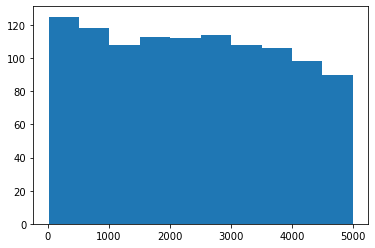

KeyboardInterrupt: 

In [32]:
while True:
    clear_output(wait=True)
    df = spark.sql('SELECT quantity,price, symbol FROM BUY_view').toPandas()
    plt.hist(df['quantity'] )
    plt.pause(5)
   

In [33]:
BUY_stream.stop()

## Part 4 - Build ML model
We believe it would be useful to predict whether a trade was a buy or sell trade based on the quantity, price account and stock code.

### Read Data from Parquet Sink

In [68]:
parquetFile = spark.read.option("mergeSchema", "true").parquet("../data/parquet_output")

In [69]:
parquetFile.describe().show()


+-------+---------+----------------+----+------------------+------------------+------+-------+------+
|summary|event_key|     event_topic|side|          quantity|             price|symbol|account|userid|
+-------+---------+----------------+----+------------------+------------------+------+-------+------+
|  count|        0|            7640|7640|              7640|              7640|  7640|   7640|  7640|
|   mean|     null|            null|null|2508.0336387434554|496.64829842931937|  null|   null|  null|
| stddev|     null|            null|null| 1428.720525097279| 288.1620311483794|  null|   null|  null|
|    min|     null|STOCKTRADES_JSON| BUY|                 1|                 5|  ZBZX| ABC123|User_1|
|    max|     null|STOCKTRADES_JSON|SELL|              4999|               999| ZXZZT| XYZ789|User_9|
+-------+---------+----------------+----+------------------+------------------+------+-------+------+



In [70]:
cat_cols = ['symbol','account','userid']
cols = ["side",'quantity','price','symbol','account','userid']

In [109]:
df = parquetFile.select(cols)


In [110]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [111]:
stages = []
for cat_col in cat_cols:
    col_indexer = StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}_ind")
    col_encoder = OneHotEncoder(inputCols=[f"{cat_col}_ind"], outputCols=[f"{cat_col}_ohe"])
    stages += [col_indexer, col_encoder]

In [112]:
num_cols = ["quantity","price"]

In [113]:
cat_cols_ohe = [f"{cat_col}_ohe" for cat_col in cat_cols]

In [114]:
assembler = VectorAssembler(inputCols=cat_cols_ohe + num_cols, outputCol="features")

In [115]:
stages += [assembler]


In [116]:
from pyspark.ml import Pipeline

In [117]:
pipeline = Pipeline(stages=stages)

### Build X Column

In [118]:
df.show(5)


+----+--------+-----+------+-------+------+
|side|quantity|price|symbol|account|userid|
+----+--------+-----+------+-------+------+
| BUY|    3730|   69|   ZVV| XYZ789|User_8|
|SELL|    1632|  985| ZXZZT| ABC123|User_3|
| BUY|    2563|  969| ZWZZT| ABC123|User_4|
| BUY|    2780|  945| ZXZZT| XYZ789|User_4|
|SELL|    3460|  830| ZVZZT| XYZ789|User_6|
+----+--------+-----+------+-------+------+
only showing top 5 rows



In [119]:
pipeline_model = pipeline.fit(df)

In [120]:
df = pipeline_model.transform(df)

In [121]:
df.show(5)

+----+--------+-----+------+-------+------+----------+-------------+-----------+-------------+----------+-------------+--------------------+
|side|quantity|price|symbol|account|userid|symbol_ind|   symbol_ohe|account_ind|  account_ohe|userid_ind|   userid_ohe|            features|
+----+--------+-----+------+-------+------+----------+-------------+-----------+-------------+----------+-------------+--------------------+
| BUY|    3730|   69|   ZVV| XYZ789|User_8|       5.0|(6,[5],[1.0])|        1.0|(2,[1],[1.0])|       3.0|(8,[3],[1.0])|(18,[5,7,11,16,17...|
|SELL|    1632|  985| ZXZZT| ABC123|User_3|       2.0|(6,[2],[1.0])|        0.0|(2,[0],[1.0])|       0.0|(8,[0],[1.0])|(18,[2,6,8,16,17]...|
| BUY|    2563|  969| ZWZZT| ABC123|User_4|       0.0|(6,[0],[1.0])|        0.0|(2,[0],[1.0])|       4.0|(8,[4],[1.0])|(18,[0,6,12,16,17...|
| BUY|    2780|  945| ZXZZT| XYZ789|User_4|       2.0|(6,[2],[1.0])|        1.0|(2,[1],[1.0])|       4.0|(8,[4],[1.0])|(18,[2,7,12,16,17...|
|SELL|    346

In [122]:
from pyspark.ml.feature import StandardScaler

In [123]:
df = df.select(['features','side'])

In [124]:
df.show(5)

+--------------------+----+
|            features|side|
+--------------------+----+
|(18,[5,7,11,16,17...| BUY|
|(18,[2,6,8,16,17]...|SELL|
|(18,[0,6,12,16,17...| BUY|
|(18,[2,7,12,16,17...| BUY|
|(18,[7,13,16,17],...|SELL|
+--------------------+----+
only showing top 5 rows



### Scale X Features

In [125]:
xscaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [126]:
xscalerModel = xscaler.fit(df)

In [129]:
xscalerModel.save("../models/xscaler")

Py4JJavaError: An error occurred while calling o2722.save.
: java.io.IOException: Path ../models/xscaler already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)


In [130]:
df = xscalerModel.transform(df)

In [131]:
df.show(5)


+--------------------+----+--------------------+
|            features|side|      scaledFeatures|
+--------------------+----+--------------------+
|(18,[5,7,11,16,17...| BUY|(18,[5,7,11,16,17...|
|(18,[2,6,8,16,17]...|SELL|(18,[2,6,8,16,17]...|
|(18,[0,6,12,16,17...| BUY|(18,[0,6,12,16,17...|
|(18,[2,7,12,16,17...| BUY|(18,[2,7,12,16,17...|
|(18,[7,13,16,17],...|SELL|(18,[7,13,16,17],...|
+--------------------+----+--------------------+
only showing top 5 rows



### Convert target Variable

In [132]:
yencoder = StringIndexer(inputCol='side', outputCol="target")

In [133]:
y_coder = yencoder.fit(df)

In [134]:
df = y_coder.transform(df)

### Split into Training and Test sets

In [135]:
df_train, df_test = df.randomSplit([0.7,0.3], seed = 42)

In [136]:
df_train.show()

+--------------------+----+--------------------+------+
|            features|side|      scaledFeatures|target|
+--------------------+----+--------------------+------+
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|

In [137]:
df_test.show()

+--------------------+----+--------------------+------+
|            features|side|      scaledFeatures|target|
+--------------------+----+--------------------+------+
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|

### Train model

In [138]:
from pyspark.ml.classification import LogisticRegression

In [139]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8,featuresCol='scaledFeatures', labelCol = 'target')

In [140]:
lrModel = lr.fit(df_train)

## Make predictions on Training Set

In [142]:
train_preds_dt = lrModel.transform(df_train)

In [143]:
test_preds_dt = lrModel.transform(df_test)

In [144]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [147]:
test_preds_dt.show(5)

+--------------------+----+--------------------+------+--------------------+--------------------+----------+
|            features|side|      scaledFeatures|target|       rawPrediction|         probability|prediction|
+--------------------+----+--------------------+------+--------------------+--------------------+----------+
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|[0.01844390165925...|[0.50461084470675...|       0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|[0.01844390165925...|[0.50461084470675...|       0.0|
|(18,[0,6,8,16,17]...|SELL|(18,[0,6,8,16,17]...|   0.0|[0.01844390165925...|[0.50461084470675...|       0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|[0.01844390165925...|[0.50461084470675...|       0.0|
|(18,[0,6,8,16,17]...| BUY|(18,[0,6,8,16,17]...|   1.0|[0.01844390165925...|[0.50461084470675...|       0.0|
+--------------------+----+--------------------+------+--------------------+--------------------+----------+
only showing top 5 

In [169]:
predictionAndLabels = test_preds_dt.rdd.map(lambda lp: (lp.prediction,float(lp.target)))


In [170]:
metrics = BinaryClassificationMetrics(predictionAndLabels)

In [171]:
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.5


In [172]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [173]:
metrics = MulticlassMetrics(predictionAndLabels)

In [174]:
print(metrics.confusionMatrix().toArray())

[[1100.    0.]
 [1118.    0.]]
